# ML1 - Autoencoder for Snippets
Now that we have the snippets of all songs, we can use them to train ML1. We will use the architecture of a variational convolutional autoencoder. The code relies heavily on the tutorial of Valerio Velardo (see here: https://www.youtube.com/watch?v=Ey8IZQl_lKs&list=PL-wATfeyAMNpEyENTc-tVH5tfLGKtSWPp)
We use a variational convolutional autoencoder as we hope that the latent space is more likely to be centered around the origin of a coordinate system and more evenly filled, then with a common autoencoder. That hopefully facilitates the task for ML2 - as can be seen later.


## VAE class

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, \
    Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.compat.v1.disable_eager_execution()

"""
-------------------------------------------
AUTOENCODER CLASS
-------------------------------------------
"""


class VAE:

    def __init__(self, input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim, num_of_train_data=0):
        self.input_shape = input_shape  # dimension of input data: frequency-bins, time-windows, amplitude
        self.conv_filters = conv_filters  # a list with the number of filters per layer
        self.conv_kernels = conv_kernels  # a list with the kernel size per layer
        self.conv_strides = conv_strides  # a list with the strides per layer
        self.latent_space_dim = latent_space_dim
        self.reconstruction_loss_weight = 1000000
        self._shape_before_bottleneck = None

        self.encoder = None
        self.decoder = None
        self.model = None
        self.model_input = None
        self.num_of_train_data = num_of_train_data

        self._num_conv_layers = len(conv_filters)

        self._build()

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    """ 
    ------------
    Encoder Part 
    ------------
    """

    def _build_encoder(self):
        encoder_input = Input(shape=self.input_shape, name="encoder_input")
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_conv_layers(self, encoder_input):
        x = encoder_input

        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_index + 1}")
        x = conv_layer(x)  # apply the new conv to x -> Convolution with kernels give multiple 2D Arrays
        x = ReLU(name=f"encoder_relu_{layer_index + 1}")(x)  # apply a ReLU activation to x
        x = BatchNormalization(name=f"encoder_bn_{layer_index + 1}")(
            x)  # apply Batch Normalization to x
        # (less overfitting-problems, no vanishing Gradient or exploding Gradient)
        return x

    def _add_bottleneck(self, x):
        self._shape_before_bottleneck = K.int_shape(x)[1:]  # Ignore the first dim, which is the batch size
        x = Flatten(name="encoder_flatten")(x)  # Flatten Data

        # Gaussian Sampling: Sample a point in the gaussian distribution from a point in standard normal distribution
        self.mu = Dense(self.latent_space_dim, name="min_vector_mu")(x)
        self.log_variance = Dense(self.latent_space_dim, name="log_variance")(x)

        """
        def sample_point_from_normal_dist(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape=K.shape(self.latent_space_dim), mean=0., stddev=1.)
            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            return sampled_point

        x = Lambda(sample_point_from_normal_dist,
                   name="encoder_output")([self.mu, self.log_variance])
        """
        x = LambdaLayer(self.latent_space_dim)([self.mu, self.log_variance])
        return x

    """
    ------------
    Decoder Part 
    ------------
    """

    def _build_decoder(self):
        decoder_input = Input(shape=self.latent_space_dim, name="decoder_input")
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = Reshape(self._shape_before_bottleneck, name="decoder_reshape_layer")(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(
            self._shape_before_bottleneck)  # Product of the dimensions before the latent space
        # -> Size of the flattened data before Latent Space
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_conv_transpose_layers(self, x):
        for layer_index in reversed(range(1,
                                          self._num_conv_layers)):  # go backwards trough layers.
            # Ignore the first layer, because we don't need
            # ReLU or BN on it
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers - layer_index}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{self._num_conv_layers - layer_index}")(x)
        x = BatchNormalization(name=f"decoder_bn_{self._num_conv_layers - layer_index}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=self.input_shape[-1],  # We want to recreate the input shape
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="decoder_output_sigmoid")(x)
        return output_layer

    """
    ------------
    VAE Part 
    ------------
    """

    def compile_model(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[self.calculate_reconstruction_loss])

    def _calculate_combined_loss(self, y_true, y_pred):
        reconstruction_loss = self.calculate_reconstruction_loss(y_true, y_pred)
        kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) - K.exp(self.log_variance), axis=1)
        loss = (self.reconstruction_loss_weight * reconstruction_loss) + kl_loss

        return loss

    @staticmethod
    def calculate_reconstruction_loss(y_true, y_pred):
        # Mean Squared Error
        error = y_true - y_pred
        reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])  # mean squared error
        return reconstruction_loss

    def train(self, x_train, x_test, batch_size, num_epochs):
        self.num_of_train_data += x_train.shape[0]
        hist = self.model.fit(x_train,
                              x_train,
                              batch_size=batch_size,
                              epochs=num_epochs,
                              shuffle=True,
                              validation_data=(x_test, x_test)
                              )
        return hist

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="Valerio")

    def summary(self):
        self.model.summary()
        self.encoder.summary()
        self.decoder.summary()

    """
    ------------------
    Saving and Loading
    ------------------
    """

    def save(self, save_folder="."):
        self._create_folder(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)
        self._save_optimizer_state(save_folder)
        model_save_path = os.path.join(save_folder, "model.h5")
        self.model.save(model_save_path)

    def _create_folder(self, save_folder):
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim,
            self.num_of_train_data
        ]

        save_path = os.path.join(save_folder, "parameters.pkl")

        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    def _save_optimizer_state(self, save_folder):
        # Save optimizer weights.
        symbolic_weights = getattr(self.model.optimizer, 'weights')
        weight_values = K.batch_get_value(symbolic_weights)
        optimizer_path = os.path.join(save_folder, "optimizer.pkl")
        with open(optimizer_path, 'wb') as f:
            pickle.dump(weight_values, f)

    @classmethod
    def load(cls, save_folder=".", learning_rate=0.0001):
        # Load the parameters:
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        loaded_autoencoder = VAE(*parameters)

        # Compile the model (to be able to retrain it with additional data if needed)
        loaded_autoencoder.compile_model(learning_rate=learning_rate)

        # Load the Weights
        weights_path = os.path.join(save_folder, "weights.h5")
        loaded_autoencoder.model.load_weights(weights_path)

        # Load the Optimizer State
        loaded_autoencoder.model._make_train_function()

        optimizer_path = os.path.join(save_folder, "optimizer.pkl")
        with open(optimizer_path, 'rb') as f:
            weight_values = pickle.load(f)
        loaded_autoencoder.model.optimizer.set_weights(weight_values)

        return loaded_autoencoder


"""
-------------
Custom Layer
-------------
"""


class LambdaLayer(tf.keras.layers.Layer):
    def __init__(self, latent_space_dim):
        super(LambdaLayer, self).__init__()
        self.latent_space_dim = latent_space_dim

    def call(self, inputs):
        mu, log_variance = inputs
        epsilon = K.random_normal(shape=K.shape(self.latent_space_dim), mean=0., stddev=1.)
        sampled_point = mu + K.exp(log_variance / 2) * epsilon
        return sampled_point

    def get_config(self):
        return {'latent_space_dim': self.latent_space_dim}

    @classmethod
    def from_config(cls, config):
        return cls(**config)




## Load the Data
First we need to load the snippets we created. If you want to test this code with your own data, please change the "load_path" variable.

In [8]:
subfolder = "4.0_256"
load_path = os.path.join("data_and_models", subfolder)
load_path = os.path.join(load_path, "spectos500.npy")
data = np.load(load_path)
x_train, x_test, _, _ = train_test_split(data, data, test_size=0.2)
del data
history = None
val_history=None

## Building the VAE
Now we can build our model. Both the encoder and the decoder consist of five convolutional layers. 

In [6]:

autoencoder = VAE(
    input_shape=(x_train[0].shape[0], x_train[0].shape[1], x_train[0].shape[2]),
    conv_filters=(512, 256, 128, 64, 32),
    conv_kernels=(3, 3, 3, 3, 3),
    conv_strides=(2, 2, 2, 2, (2, 1)),
    latent_space_dim=128
)

autoencoder.summary()

print("Shape of the training data: " + str(x_train.shape))

Instructions for updating:
Colocations handled automatically by placer.
Model: "Valerio"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 256, 1)]     0         
_________________________________________________________________
encoder (Functional)         (None, 128)               2100832   
_________________________________________________________________
decoder (Functional)         (None, 128, 256, 1)       665185    
Total params: 2,766,017
Trainable params: 2,763,073
Non-trainable params: 2,944
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 256, 1) 0                                  

## Train the VAE
As we have limited memory on our machines we had to split the training process in several steps. Unfortunately the programme freezed on our machines from time to time. That's why we save the model after each step. With faster machines more epochs would have been possible, which could improve the results. 

Warning: This process can take a long time, depending on the loaded training data. If you want to train your own model, please change the "save_path" variable. If you only want to work with our trained models, don't execute the following code. Just jump to the next section "Evaluate the training process".

In [ ]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
EPOCHS = 20

autoencoder.compile_model(LEARNING_RATE)
steps = 20
history = []
val_history = []

for i in range(steps):
    num = int(x_train.shape[0] / steps) * (i + 1)
    test_num = int(x_test.shape[0] / steps) * (i + 1)

    print("Start with subset " + str(i+1) + " of " + str(steps))
    print("Train from index " + str(int(num - (num / (i + 1)))) + " to index " + str(num))
    print("Use test indices " + str(int(test_num - (test_num / (i + 1)))) + " to " + str(test_num) +
          " as validation set")

    train_subset = x_train[int(num - (num / (i + 1))):num]
    test_subset = x_test[int(test_num - (test_num / (i + 1))):test_num]

    step_history = autoencoder.train(train_subset, test_subset, BATCH_SIZE, EPOCHS)
    history.extend(step_history.history['loss'])
    val_history.extend(step_history.history['val_loss'])
    
    """
    ----------------
    Save VAE
    ----------------
    """

    save_path = os.path.join("data_and_models", subfolder)
    name = "VAE_Vocals_" + str(autoencoder.latent_space_dim) + "D_" + \
           str(autoencoder.num_of_train_data) + "samples_" + str(EPOCHS) + "Epochs"
    model_path = os.path.join(save_path, name)
    autoencoder.save(model_path)

    print("saved at: " + save_path)

## Evaluate the training process
We stored the loss of each epoch of each step of the training and can look at it. This graph shows how the loss gets less with every epoch. The loss is defined as the mean-squared error between a given mel-spectogram and the mel-spectogram reproduced by the decoder.

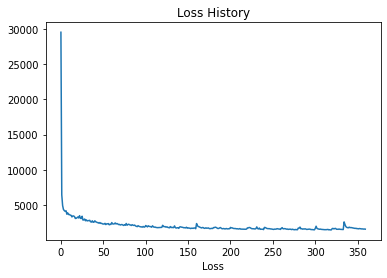

In [12]:
save_path = os.path.join("data_and_models", subfolder)

if history is not None:
    """
    Save the History
    """
    history = np.asarray(history)
    val_history = np.asarray(val_history)

    hist_save_path = os.path.join(save_path, "history.npy")
    val_hist_save_path = os.path.join(save_path, "val_history.npy")



    with open(hist_save_path, 'wb') as f:
        np.save(f, history)
        np.save(f, val_history)
else:
    hist_save_path = os.path.join(save_path, "history.npy")
    with open(hist_save_path, 'rb') as f:
         history = np.load(f)
         val_history = np.load(f)

plt.figure()
plt.plot(history)
plt.xlabel("Epochs")
plt.xlabel("Loss")
plt.title("Loss History")
plt.show()

# plt.figure()
# plt.plot(val_history)
# plt.xlabel("Epochs")
# plt.xlabel("Validation Loss")
# plt.title("Validation Loss History")
# plt.show()